<a href="https://colab.research.google.com/github/soyyoon/ML_project/blob/main/data_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import random
import time
from glob import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')

mnist_data = np.load('/content/drive/MyDrive/ML_Project/mnist_train.npz')
X_train_original = mnist_data['train_images']
y_train_original = mnist_data['train_labels']

FONT_PATHS = glob('/content/drive/MyDrive/ML_Project/fonts/**/*.ttf', recursive=True)

IMAGE_SIZE = (28, 28)
FONT_SIZE = 25

# 색상 팔레트 및 라벨 인코딩
RAINBOW_NAMES = ['RED', 'ORANGE', 'YELLOW', 'GREEN', 'BLUE', 'INDIGO', 'VIOLET']
RAINBOW_COLORS_RGB = [
    (255, 0, 0), (255, 127, 0), (255, 255, 0), (0, 255, 0),
    (0, 0, 255), (75, 0, 130), (148, 0, 211)
]
COLOR_TO_LABEL = {name: i for i, name in enumerate(RAINBOW_NAMES)}
LABEL_TO_COLOR_NAME = {i: name for i, name in enumerate(RAINBOW_NAMES)}
print("\n색상 라벨 인코딩 설정 완료.")
print(COLOR_TO_LABEL)

Mounted at /content/drive

색상 라벨 인코딩 설정 완료.
{'RED': 0, 'ORANGE': 1, 'YELLOW': 2, 'GREEN': 3, 'BLUE': 4, 'INDIGO': 5, 'VIOLET': 6}


### 색상 함수

In [ ]:
def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 (RGB, 이름) 튜플을 반환합니다."""
    idx = np.random.randint(0, len(RAINBOW_COLORS_RGB))
    return RAINBOW_COLORS_RGB[idx], RAINBOW_NAMES[idx]

def colorize_digit_with_threshold(digit_image_pil, fg_color, bg_color):
    """PIL 이미지에 경계선 번짐 없이 선명한 전경/배경 색을 적용합니다."""
    # 그레이스케일 이미지로 변환하여 마스크 생성
    mask = digit_image_pil.convert('L').point(lambda p: 255 if p > 128 else 0)

    # 배경색으로 채워진 새 RGB 이미지 생성
    final_image = Image.new("RGB", digit_image_pil.size, bg_color)

    # 마스크를 이용해 전경색 붙여넣기
    final_image.paste(fg_color, mask=mask)
    return final_image

# --- 이미지 소스 관련 함수 ---
# 원본 MNIST 이미지를 숫자별로 미리 분류하여 딕셔너리에 저장 (효율성 증대)
mnist_images_by_label = {i: [] for i in range(10)}
for img, lbl in zip(X_train_original, y_train_original):
    mnist_images_by_label[lbl].append(img)

def get_mnist_image_for_digit(digit):
    """특정 숫자에 해당하는 원본 MNIST 이미지를 랜덤하게 PIL 이미지로 반환합니다."""
    images_list = mnist_images_by_label[digit]
    random_image_np = random.choice(images_list)
    return Image.fromarray(random_image_np.astype('uint8')) # 'L': 8-bit grayscale

def generate_digit_image_from_font(digit, font_path):
    """주어진 폰트로 특정 숫자 이미지를 생성하여 PIL 이미지로 반환합니다."""
    image = Image.new("L", IMAGE_SIZE, 0)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, FONT_SIZE)

    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width = bbox[2] - bbox[0]
    position = ((IMAGE_SIZE[0] - text_width) // 2, -3) # 위치 미세 조정
    draw.text(position, str(digit), fill=255, font=font)
    return image

### 데이터 생성 함수

In [ ]:
def create_colored_dataset(num_samples, mnist_ratio):
    """
    지정된 개수만큼 컬러 데이터셋을 생성합니다.
    - num_samples: 생성할 샘플의 총 개수
    - mnist_ratio: 원본 MNIST 이미지 소스를 사용할 비율 (나머지는 폰트 사용)
    """
    X_data, y_data_digit, y_data_fg, y_data_bg = [], [], [], []

    samples_per_class = num_samples

    print(f"\n총 {num_samples}개의 데이터 생성을 시작합니다 (MNIST 비율: {mnist_ratio*100}%)")
    start_time = time.time()

    for _ in tqdm(range(num_samples)):
        # 1. 라벨 생성
        digit_label = random.randint(0, 9)
        fg_color_rgb, fg_name = get_random_rainbow_color()
        bg_color_rgb, bg_name = get_random_rainbow_color()
        while fg_color_rgb == bg_color_rgb:
            bg_color_rgb, bg_name = get_random_rainbow_color()
        fg_label = COLOR_TO_LABEL[fg_name]
        bg_label = COLOR_TO_LABEL[bg_name]

        # 2. 베이스 이미지 생성 (MNIST or Font)
        if random.random() < mnist_ratio:
            base_image_pil = get_mnist_image_for_digit(digit_label)
        else:
            font_path = random.choice(FONT_PATHS)
            base_image_pil = generate_digit_image_from_font(digit_label, font_path)

        # 3. 이미지 색칠하기
        colorized_image_pil = colorize_digit_with_threshold(base_image_pil, fg_color_rgb, bg_color_rgb)

        # 4. 전처리 및 저장 (0.0 ~ 1.0 정규화)
        image_np_normalized = np.array(colorized_image_pil) / 255.0

        X_data.append(image_np_normalized)
        y_data_digit.append(digit_label)
        y_data_fg.append(fg_label)
        y_data_bg.append(bg_label)

    end_time = time.time()
    print(f"데이터 생성 완료! (소요 시간: {end_time - start_time:.2f}초)")

    # 최종 Numpy 배열로 변환
    return (np.array(X_data, dtype=np.float32),
            np.array(y_data_digit, dtype=np.int32),
            np.array(y_data_fg, dtype=np.int32),
            np.array(y_data_bg, dtype=np.int32))

### 데이터 생성

In [ ]:
X_train_gen, y_train_digit, y_train_fg, y_train_bg = create_colored_dataset(
    num_samples=60000, mnist_ratio=0.8
)

# 검증용 1만개 (MNIST 80% : 폰트 20%)
X_val_gen, y_val_digit, y_val_fg, y_val_bg = create_colored_dataset(
    num_samples=10000, mnist_ratio=0.8
)

print("\n--- 생성된 데이터셋 Shape ---")
print(f"Train X: {X_train_gen.shape}, Train y_digit: {y_train_digit.shape}")
print(f"Val X: {X_val_gen.shape},  val y_digit: {y_val_digit.shape}")


SAVE_PATH_TRAIN = '/content/drive/MyDrive/ML_Project/colored_mnist_train.npz'
SAVE_PATH_VAL = '/content/drive/MyDrive/ML_Project/colored_mnist_val.npz'

print("\n생성된 데이터셋을 NPZ 파일로 저장합니다...")
np.savez_compressed(
    SAVE_PATH_TRAIN,
    images=X_train_gen,
    labels_digit=y_train_digit,
    labels_fg=y_train_fg,
    labels_bg=y_train_bg
)
np.savez_compressed(
    SAVE_PATH_VAL,
    images=X_val_gen,
    labels_digit=y_val_digit,
    labels_fg=y_val_fg,
    labels_bg=y_val_bg
)
print(f"학습 데이터 저장 완료: {SAVE_PATH_TRAIN}")
print(f"테스트 데이터 저장 완료: {SAVE_PATH_VAL}")


총 60000개의 데이터 생성을 시작합니다 (MNIST 비율: 80.0%)


  0%|          | 0/60000 [00:00<?, ?it/s]

데이터 생성 완료! (소요 시간: 78.08초)

총 10000개의 데이터 생성을 시작합니다 (MNIST 비율: 80.0%)


  0%|          | 0/10000 [00:00<?, ?it/s]

데이터 생성 완료! (소요 시간: 13.07초)

--- 생성된 데이터셋 Shape ---
Train X: (60000, 28, 28, 3), Train y_digit: (60000,)
Val X: (10000, 28, 28, 3),  val y_digit: (10000,)

생성된 데이터셋을 NPZ 파일로 저장합니다...
학습 데이터 저장 완료: /content/drive/MyDrive/ML_Project/colored_mnist_train.npz
테스트 데이터 저장 완료: /content/drive/MyDrive/ML_Project/colored_mnist_val.npz


### 데이터 생성 검증

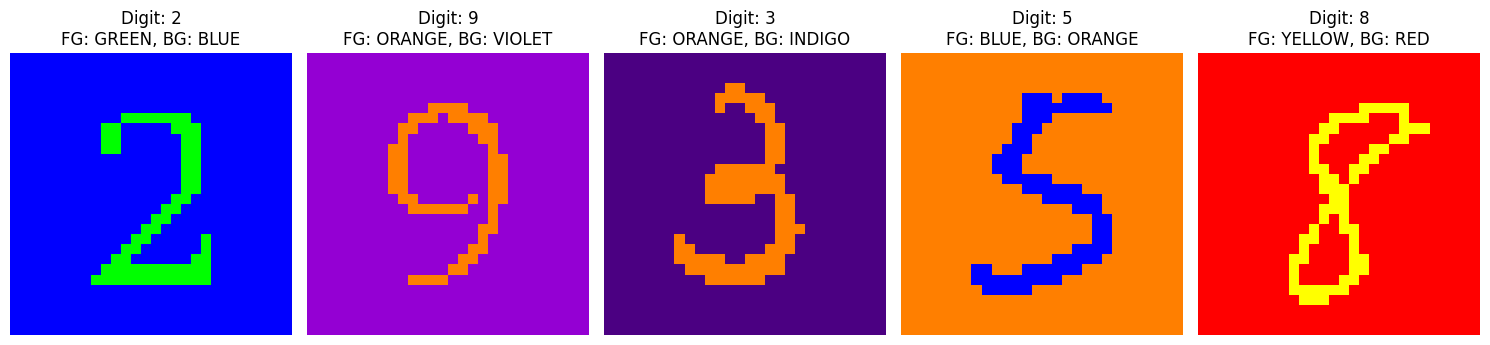

In [ ]:
# 저장된 학습 데이터 불러오기
verify_data = np.load(SAVE_PATH_TRAIN)
X_verify = verify_data['images']
y_digit_verify = verify_data['labels_digit']
y_fg_verify = verify_data['labels_fg']
y_bg_verify = verify_data['labels_bg']

# 5개의 랜덤 샘플 시각화
plt.figure(figsize=(15, 4))
for i in range(5):
    idx = random.randint(0, len(X_verify) - 1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(X_verify[idx])

    digit = y_digit_verify[idx]
    fg_color_name = LABEL_TO_COLOR_NAME[y_fg_verify[idx]]
    bg_color_name = LABEL_TO_COLOR_NAME[y_bg_verify[idx]]

    plt.title(f"Digit: {digit}\nFG: {fg_color_name}, BG: {bg_color_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

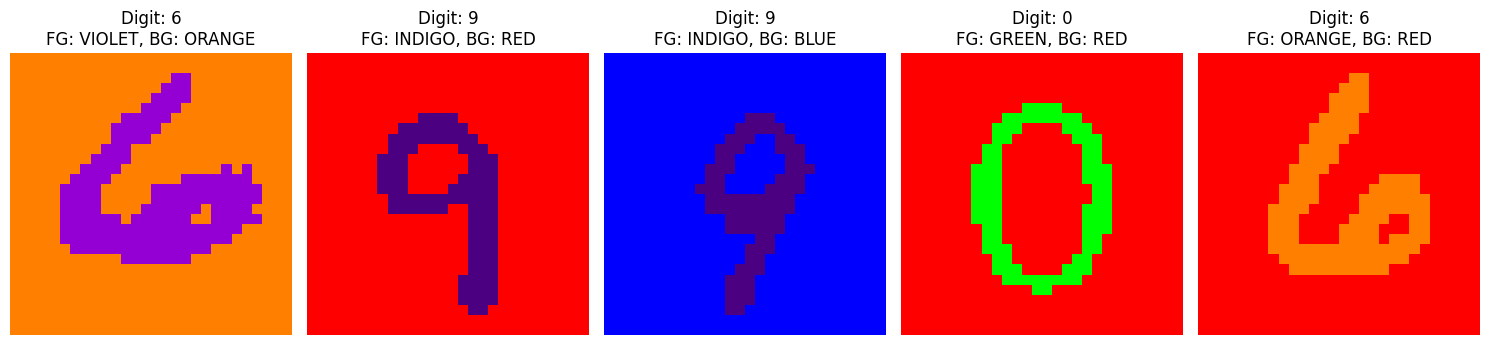

In [ ]:
# 저장된 학습 데이터 불러오기
verify_data = np.load(SAVE_PATH_VAL)
X_verify = verify_data['images']
y_digit_verify = verify_data['labels_digit']
y_fg_verify = verify_data['labels_fg']
y_bg_verify = verify_data['labels_bg']

# 5개의 랜덤 샘플 시각화
plt.figure(figsize=(15, 4))
for i in range(5):
    idx = random.randint(0, len(X_verify) - 1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(X_verify[idx])

    digit = y_digit_verify[idx]
    fg_color_name = LABEL_TO_COLOR_NAME[y_fg_verify[idx]]
    bg_color_name = LABEL_TO_COLOR_NAME[y_bg_verify[idx]]

    plt.title(f"Digit: {digit}\nFG: {fg_color_name}, BG: {bg_color_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()